<!-- title: "Comparing Decision Tree and Random Forest Classifier Performance"
format:
  html:
    code-fold: true
jupyter: python3 -->
**Author: Daniel Hassler**

<link rel="stylesheet" type="text/css" href="./index.css">
<div class="social-icons">
  <a href="https://github.com/hassledw"><i class="fab fa-github"></i></a>
  <a href="https://www.linkedin.com/in/daniel-hassler-85027a21a/"><i class="fab fa-linkedin"></i></a>
  <!-- Add more social media links/icons as needed -->
</div>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## Data Analysis
Clustering algorithms can be applied to many real-world applications, including but not limited to security, anomaly detection, document clustering, stock market analysis, image compression, and so much more. The application I decided to approach with clustering is a song recommendation system. I found a dataset on Kaggle containing almost `114,000` songs from the popular music streaming platform Spotify. Each entry in the dataset consists of many features including `artists`, `track_name`, `track_genre`, `popularity`, `danceability`, and many more. 

Before I dive into the visualizaitons, I first dropped duplicates in the dataset to minimize problems with recommendations. Now, below are some visualizations showcasing certain features in a scatterplot. This gives me a rough idea what the dataset looks like with all of these features and genres.


Index(['Unnamed: 0.1', 'index', 'Unnamed: 0', 'track_id', 'artists',
       'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'track_genre'],
      dtype='object')
(81344, 23)


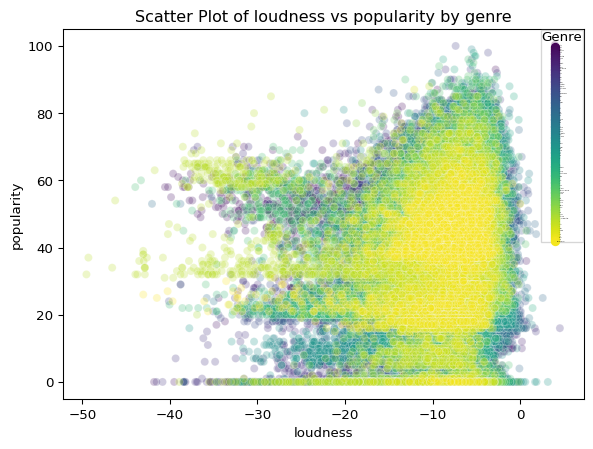

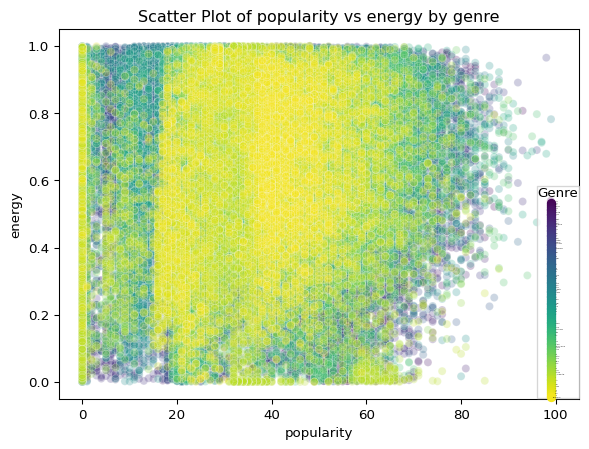

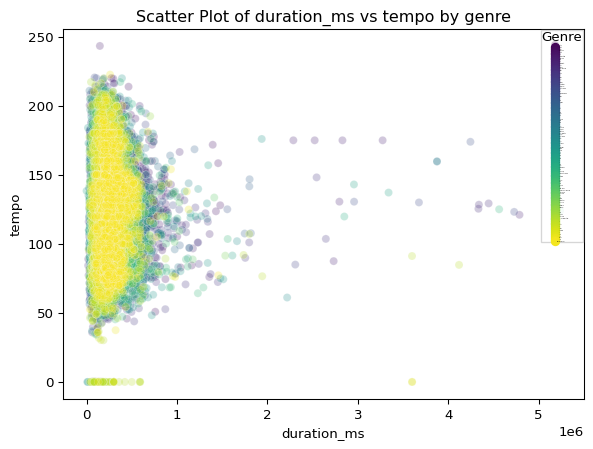

In [2]:
original_df = pd.read_csv("./dataset-dedup.csv")
print(original_df.columns)
# original_df = original_df.drop_duplicates(subset=["artists", "track_name"], keep="first").reset_index()
print(original_df.shape)
# original_df.to_csv("./dataset-dedup.csv")
features_x = ["loudness", "popularity", "duration_ms"]
features_y = ["popularity", "energy", "tempo"]

for i, (x,y) in enumerate(zip(features_x, features_y)):
    scatter = sns.scatterplot(x=x, y=y, hue='track_genre', data=original_df, palette="viridis", alpha=0.25)
    legend_labels = original_df['track_genre'].unique()# [:3]  # Show only the first 3 genres
    scatter.legend(title='Genre', labels=legend_labels, prop={'size': 1})
    plt.title(f"Scatter Plot of {x} vs {y} by genre")
    plt.show()

plt.show()

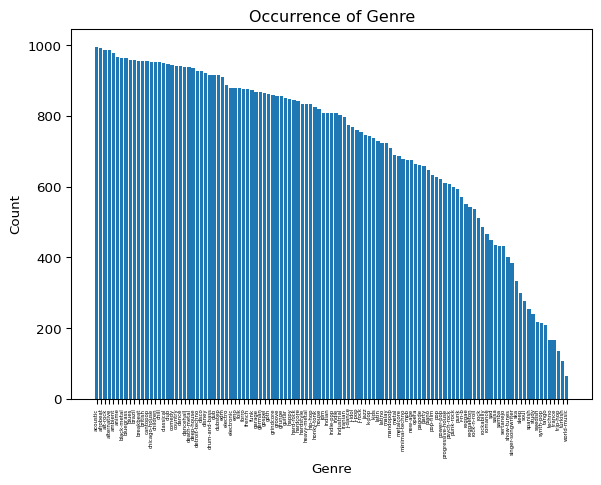

In [3]:
unique_vals = original_df['track_genre'].unique()
plt.bar(unique_vals, original_df['track_genre'].value_counts())
plt.title("Occurrence of Genre")
plt.ylabel("Count")
plt.xlabel("Genre")
_ = plt.xticks(rotation="vertical", fontsize=4)

Because a lot of these continuous variables: `loudness`, `popularity`, `duration_ms` overlap by genre significantly, I decided to drop these features during training, as well as many other features like `energy`, `danceability`, `acousticness`, as these metrics are too complex, overlapping, and even subjective. As a Spotify consumer myself, I like when Spotify gives me songs related to the current artist I'm listening to, so I thought important features in this dataset included: `artists`, `track_genre`, minimally. Although, I did try other features like `key`, and `tempo` on top of that.

## K-Means
The K-Means algorithm clusters data by minimizing a criteria known as `intertia`, the within-cluster sum-of-squares. The formula for inertia, specified in the K-means documentation for Sklearn, is noted below:

Noting some of the variables in the summation: `n` is the number of datapoints, `mu` is the mean of the cluster, also the cluster_centroid of the cluster `C`, `||x_i - \mu||^2` represents the squared euclidean distance between point `x_i` and the centroid, and min() takes the min of the calculation

$$
\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)
$$

It is worth noting that the inertia method has some drawbacks. According to Sklearn, intertia makes the assumption that clusters are convex and isotropic, which may not always be the case. The documentation also states that inertia isn't a "normalized metric", so running PCA (principal component analysis) before the K-means clustering is beneficial (which is exactly what I did in later steps).

A great benefit to K-means is its scalability to large sample sets, which is good for this problem since there are now `81,344` points.

### Hyperparameter Tuning
The biggest hyperparameter for K-means is the number of clusters `n_clusters`. This hyperparameter is the amount of clusters to generate for the problem. Because the number of clusters largely effects the results of the model, it is important to tune this. In order to chose the best value, I loop through different values up to 80.


In [4]:
inertia = []
# train_df is the numeric representation of original_df
train_df = original_df.drop(columns=['Unnamed: 0.1', 'index', 'Unnamed: 0', 'track_id',
       'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit',
       'danceability', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature'])

for col in train_df.columns:
    if not pd.api.types.is_numeric_dtype(train_df[col]):
        train_df[col] = pd.factorize(original_df[col])[0]

scaler = StandardScaler()
# df_scaled is the scaled version of train_df
df_scaled = scaler.fit_transform(train_df)
pca_num_components = 2

# df_pca to reduce dimensionality
pca = PCA(n_components=pca_num_components).fit_transform(df_scaled)
df_pca = pd.DataFrame(pca,columns=['pca1','pca2'])

for k in range(1, 80, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit_predict(df_pca)
    inertia.append(kmeans.inertia_)

D:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


D:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


D:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


D:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


D:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


D:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


D:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


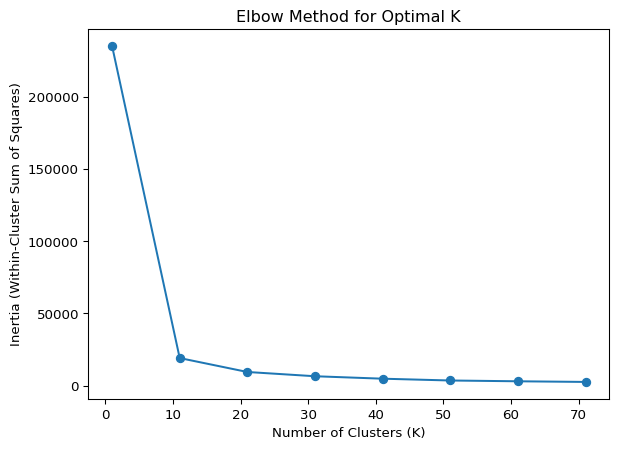

In [5]:
plt.plot(range(1, 80, 10), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.show()

The elbow chart is a great way to visualize intertia vs number of clusters on the dataset. Since our goal is to generalize well, it's not the best to choose the "lowest" inertia value. It is generally recommended in practice to choose the "elbow point"; I chose `10` as this looks very close to an elbow point for this distribution. Although, one drawback to this approach is its subjectiveness-- you might think the elbow point is 12, whereas I think the elbow point is 10.

### K-Means for Spotify
After taking the resulting elbow point, I run that through my own instance of kmeans, utilizing the Sklearn library, and store the predicted results into the original dataframe.


In [6]:
kmeans = KMeans(n_clusters=10, random_state=42)
original_df['clusters'] = kmeans.fit_predict(df_pca)

D:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


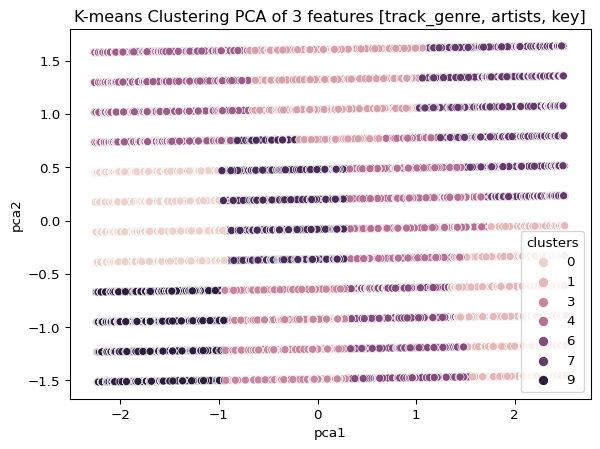

In [7]:
sns.scatterplot(x="pca1", y="pca2", hue=original_df['clusters'], data=df_pca)
plt.title('K-means Clustering PCA of 3 features [track_genre, artists, key]')
plt.show()

This is a PCA visualization of the clusters on the feature set `track_genre`, `artists` and `key`. 

## Evaluating K-Means for Spotify
Below are some sample mini-clusters. Since the goal of this overall problem is to recommend music based on certain songs, I decided to create a function that grabs an entry from the CSV file, finds the cluster it's in, and computes the k-nearest neighbors of that song. These nearest neighbors would be the "recommendation" songs, in order.

The general idea we should see with these mini-clusters are songs that resemble the query song. In the case of the first example, I ran my function on Daughtry's song "Home". The recommended song (top 1) example was another Daughtry song "It's Not Over".

When testing out different K-means implementations on different features, I found that simplicity is key. Having a ton of features is great for any dataset, but knowing how they interact with each other and how to simplify the problem makes for better results. I tested many different subsests of features including:

1. all of the original dataset features (n=20)
2. subset of continuous variables
3. subset of just track_genre and artists
4. subset of track_genre, artists, tempo, and key. All of which are discrete, factual features.
5. subset of track_genre, artists, and key.

My final result ended up being the last option, although those did not generate the most `similar` clusters, especially compared to option 3. Although, I chose the last option as I was trying to find similar songs while spanning across other artists. Option 5 seemed to give me similar options across at least one or more genres with different artists. It is worth noting that some of the results gave me the same artists, which is good since those are similar songs too. 


In [8]:
original_df['Distance_to_Centroid'] = kmeans.transform(df_pca).min(axis=1)

def get_nearest_entry(idx, k=5):
    # print(original_df.iloc[idx])
    # print(train_df.iloc[idx])
    cluster = kmeans.predict(df_pca.iloc[idx].to_frame().T)[0]
    cluster_data = original_df[original_df["clusters"] == cluster]
    cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
    cluster_data = cluster_data.sort_values(by="closest_entries_to_idx")
    # print(cluster_data[["artists", "album_name", "track_name", "track_genre"]])

    cluster_data.drop(columns=["closest_entries_to_idx"])
    print(f"Top {k} Closest Examples to {cluster_data.loc[idx]['artists']}'s \"{cluster_data.loc[idx]['track_name']}\"")
    print(cluster_data[:k][["artists", "track_name", "track_genre"]])
    print("\n\n")

get_nearest_entry(35640) # rock song
get_nearest_entry(16587) # country song
get_nearest_entry(41220) # rap song

Top 5 Closest Examples to Daughtry's "September"
            artists               track_name     track_genre
35640      Daughtry                September          grunge
35381      Daughtry            It's Not Over          grunge
35839    Stone Sour                 Hesitate          grunge
55666    Mark Broom                Five/Four  minimal-techno
40063  TNT;POPR3B3L  I'm Raving - Radio Edit       hardstyle



Top 5 Closest Examples to Florida Georgia Line's "Stay"
                    artists  \
16587  Florida Georgia Line   
8395    Datsik;Virtual Riot   
8582            The Prodigy   
8819            The Prodigy   
8529            The Prodigy   

                                              track_name track_genre  
16587                                               Stay     country  
8395                                               Nasty   breakbeat  
8582                                               Girls   breakbeat  
8819                                  We Are The Ruffes

C:\Users\dwh71\AppData\Local\Temp\ipykernel_15984\3657151199.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
C:\Users\dwh71\AppData\Local\Temp\ipykernel_15984\3657151199.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
C:\Users\dwh71\App

Option 3 on the other hand gave me different songs for the same artists, which is fine for a recommendation system, but not what I was exactly going for. Below is a visualization of the clusters with just two features as well as its predictions.


D:\Users\dwh71\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


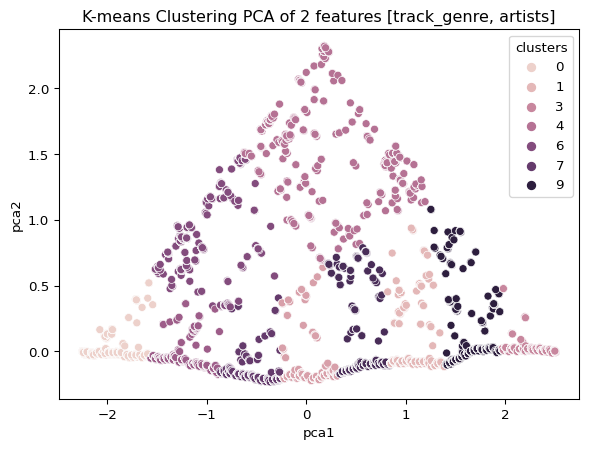

Top 5 Closest Examples to Daughtry's "September"
        artists            track_name track_genre
35439  Daughtry  Waiting for Superman      grunge
35678  Daughtry         Gone Too Soon      grunge
35802  Daughtry            I'll Fight      grunge
35640  Daughtry             September      grunge
35336  Daughtry                  Home      grunge



Top 5 Closest Examples to Florida Georgia Line's "Stay"
                    artists         track_name track_genre
16592  Florida Georgia Line  I Love My Country     country
16587  Florida Georgia Line               Stay     country
16938  Florida Georgia Line           H.O.L.Y.     country
16598  Florida Georgia Line           Sun Daze     country
16975  Florida Georgia Line               Life     country



Top 5 Closest Examples to Future;Lil Uzi Vert's "Tic Tac"
                   artists              track_name track_genre
41220  Future;Lil Uzi Vert                 Tic Tac     hip-hop
39123            Lionheart                  Cursed 

C:\Users\dwh71\AppData\Local\Temp\ipykernel_15984\3657151199.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
C:\Users\dwh71\AppData\Local\Temp\ipykernel_15984\3657151199.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data["closest_entries_to_idx"] = (cluster_data["Distance_to_Centroid"] - cluster_data.loc[idx]["Distance_to_Centroid"]).abs()
C:\Users\dwh71\App

In [9]:
original_df = pd.read_csv("./dataset-dedup.csv")
# train_df is the numeric representation of original_df
train_df = original_df.drop(columns=['Unnamed: 0.1', 'index', 'Unnamed: 0', 'track_id',
       'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit',
       'danceability', 'key', 'energy', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature'])

for col in train_df.columns:
    if not pd.api.types.is_numeric_dtype(train_df[col]):
        train_df[col] = pd.factorize(original_df[col])[0]

scaler = StandardScaler()
# df_scaled is the scaled version of train_df
df_scaled = scaler.fit_transform(train_df)
pca_num_components = 2

# df_pca to reduce dimensionality
pca = PCA(n_components=pca_num_components).fit_transform(df_scaled)
df_pca = pd.DataFrame(pca,columns=['pca1','pca2'])

kmeans = KMeans(n_clusters=10, random_state=42)
original_df['clusters'] = kmeans.fit_predict(df_pca)

sns.scatterplot(x="pca1", y="pca2", hue=original_df['clusters'], data=df_pca)
plt.title('K-means Clustering PCA of 2 features [track_genre, artists]')
plt.show()
original_df['Distance_to_Centroid'] = kmeans.transform(df_pca).min(axis=1)
get_nearest_entry(35640) # rock song
get_nearest_entry(16587) # country song
get_nearest_entry(41220) # rap song

## Conclusion
In this blog post, I used K-means as a clustering algorithm for a song recommendation system. Though K-means does a good job at coming up with clusters and generating similar examples, other clustering algorithms such as DBSCAN may be a suitable option as well. In general, what I like about clustering algorithms for this problem domain, especially K-means, is its free range to determine what logical clusters should look like and its intuitiveness. There's not only one correct way to do K-means.